In [1]:
RECON_SIZE = (360, 360)
NUM_COMPRESSED_COILS = 16

import fastmri
from fastmri.data import transforms
from fastmri.data.transforms import MiniCoilTransform
%matplotlib inline
import h5py
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import torch
from typing import Dict, NamedTuple, Optional, Sequence, Tuple, Union
from fastmri.data.transforms import to_tensor, center_crop, complex_center_crop

def to_tensor(data: np.ndarray) -> torch.Tensor:
    """
    Convert numpy array to PyTorch tensor.

    For complex arrays, the real and imaginary parts are stacked along the last
    dimension.

    Args:
        data: Input numpy array.

    Returns:
        PyTorch version of data.
    """
    if np.iscomplexobj(data):
        data = np.stack((data.real, data.imag), axis=-1)

    return torch.from_numpy(data)


def center_crop(data: torch.Tensor, shape: Tuple[int, int]) -> torch.Tensor:
    """
    Apply a center crop to the input real image or batch of real images.

    Args:
        data: The input tensor to be center cropped. It should
            have at least 2 dimensions and the cropping is applied along the
            last two dimensions.
        shape: The output shape. The shape should be smaller
            than the corresponding dimensions of data.

    Returns:
        The center cropped image.
    """
    if not (0 < shape[0] <= data.shape[-2] and 0 < shape[1] <= data.shape[-1]):
        raise ValueError("Invalid shapes.")

    w_from = (data.shape[-2] - shape[0]) // 2
    h_from = (data.shape[-1] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]

    return data[..., w_from:w_to, h_from:h_to]


def complex_center_crop(data: torch.Tensor, shape: Tuple[int, int]) -> torch.Tensor:
    """
    Apply a center crop to the input image or batch of complex images.

    Args:
        data: The complex input tensor to be center cropped. It should have at
            least 3 dimensions and the cropping is applied along dimensions -3
            and -2 and the last dimensions should have a size of 2.
        shape: The output shape. The shape should be smaller than the
            corresponding dimensions of data.

    Returns:
        The center cropped image
    """
    if not (0 < shape[0] <= data.shape[-3] and 0 < shape[1] <= data.shape[-2]):
        raise ValueError("Invalid shapes.")

    w_from = (data.shape[-3] - shape[0]) // 2
    h_from = (data.shape[-2] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]

    return data[..., w_from:w_to, h_from:h_to, :]

In [3]:
file_name = '/data/fastmri/multibrain_compressed_s320_c16_T2_new/multicoil_train/file_brain_AXT2_200_2000003.h5' # your own path
#file_name = '/data/fastmri/multiknee_compressed_s320_c4/multicoil_train/file1000021.h5'
hf = h5py.File(file_name, 'r')
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))
print(hf.attrs['max'])

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXT2', 'max': 0.0006791184, 'norm': 0.1578738, 'patient_id': '25fd0e24b51454bcc429b85d9065e80e84dd3108143570c89a47bed2494fd990'}
0.0006791184


(16, 16, 320, 320) complex64
(16, 320, 320) float32
rss_mean 8.2023966e-05 rss_max 0.0006791184


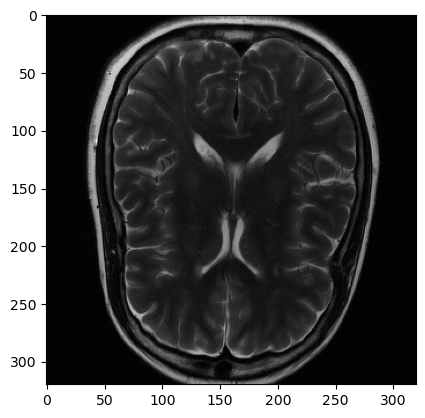

In [5]:
kspace = hf['kspace'][()]
print(kspace.shape, kspace.dtype)
reconstruction_rss = hf['reconstruction_rss'][()]
print(reconstruction_rss.shape, reconstruction_rss.dtype)
print("rss_mean", reconstruction_rss.mean(), "rss_max", reconstruction_rss.max())
plt.imshow(reconstruction_rss[1,:,:], cmap='gray')

2.8617646e-09 0.040706992


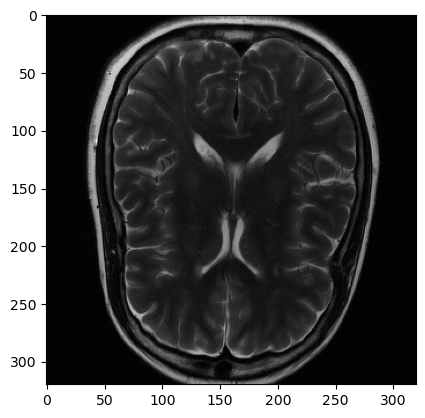

In [6]:
target = fastmri.rss_complex(fastmri.ifft2c(to_tensor(kspace[1])))
plt.imshow(target, cmap='gray')
print(np.linalg.norm(reconstruction_rss[1,:,:]-target.numpy()),np.linalg.norm(reconstruction_rss[1,:,:]))

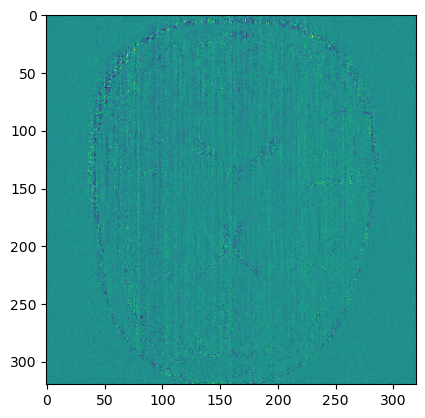

In [7]:
plt.imshow(reconstruction_rss[1,:,:]-target.numpy())

torch.Size([16, 16, 40, 40, 2])
tensor([15, 23, 16, 14, 15, 16, 14, 21, 23, 16, 17,  9, 23, 25, 21, 18, 20, 19,
        19, 20, 20, 19, 19, 19, 20, 20, 19, 17, 19, 16, 20, 20, 18, 22, 25, 18,
        24, 17, 19, 24])


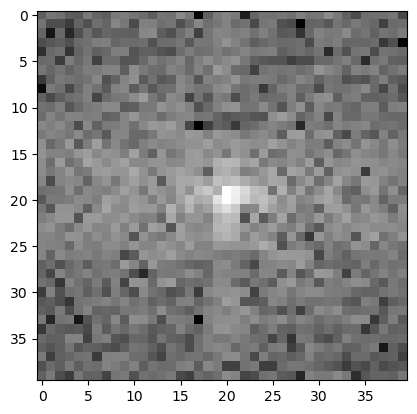

In [9]:
#np.abs(kspace[20,:,:]).argmax(axis=2)
cropped = complex_center_crop(to_tensor(kspace),(40,40))
print(cropped.shape)
print(torch.norm(cropped[1,0,:,:,:], dim=-1).argmax(axis=0))
plt.imshow(20*np.log(torch.norm(cropped[1,0,:,:,:], dim=-1).numpy()), cmap='gray')

In [13]:
low_freqs = np.zeros_like(kspace)
print(low_freqs.shape)
cropped = complex_center_crop(to_tensor(kspace),(40,40)).numpy()
low_freqs[:,:,160-20:160+20,160-20:160+20] = kspace[:,:,160-20:160+20,160-20:160+20]
#print(low_freqs[20,0,64,64], cropped[20,0,8,8,:])

(16, 16, 320, 320)


In [14]:
sampled_image = fastmri.ifft2c(to_tensor(low_freqs))           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=1)

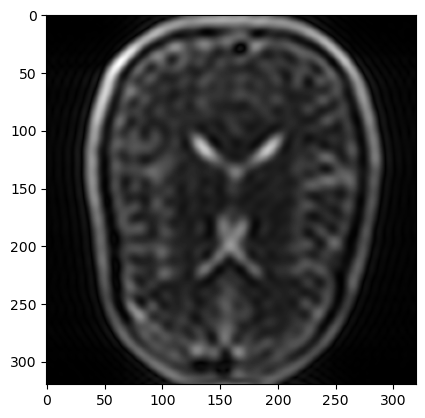

In [15]:
plt.imshow(sampled_image_rss.numpy()[1], cmap='gray')

40
8.657077e-05 8.927729e-05 8.657077e-05


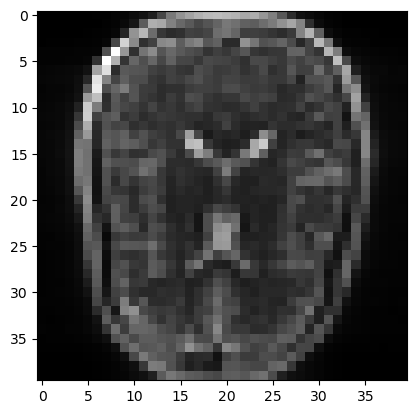

In [16]:
import skimage.measure

new_array = skimage.measure.block_reduce(sampled_image_rss.numpy()[1], (8,8), np.mean)
print(new_array.shape[0])
print(np.abs(sampled_image_rss.numpy())[1].mean(), reconstruction_rss[1,:,:].mean(), new_array.mean())
plt.imshow(new_array, cmap='gray')

In [1]:
import os
import glob
from PIL import Image
import skimage.measure
import fastmri
from fastmri.data import transforms
from fastmri.data.transforms import MiniCoilTransform
from fastmri.data.transforms import to_tensor, center_crop, complex_center_crop
%matplotlib inline
import h5py
import numpy as np
from matplotlib import pyplot as plt
import torch
from typing import Dict, NamedTuple, Optional, Sequence, Tuple, Union

SRC_root = '/data/fastmri/multiknee_compressed_s320_c16' # your own path
DST_root = '/data/fastmri/multiknee_compressed_s320_c16_LRHR' # your own path
Folders = ['/multicoil_train', '/multicoil_val']

os.mkdir(DST_root)
for folder in Folders:
    os.mkdir(DST_root + folder)
    os.mkdir(DST_root + folder + '/LR')
    os.mkdir(DST_root + folder + '/HR')
    for file_name in glob.iglob(SRC_root + folder + '/file*.h5'):
        with h5py.File(file_name, 'r') as hf:

            kspace = hf['kspace'][()]
            low_freqs=np.zeros_like(kspace)
            reconstruction_rss = hf['reconstruction_rss'][()]
            low_freqs[:,:,160-20:160+20,160-20:160+20] = kspace[:,:,160-20:160+20,160-20:160+20]
            sampled_image = fastmri.ifft2c(to_tensor(low_freqs))     # Apply Inverse Fourier Transform to get the complex image
            sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
            sampled_image_rss = fastmri.rss(sampled_image_abs, dim=1)
            M = hf.attrs['max']
            for i in range(sampled_image_rss.shape[0]):
                downsampled = skimage.measure.block_reduce(sampled_image_rss.numpy()[i], (8,8), np.mean)
                LR = np.clip((255 * downsampled  / M ),0,255).astype(np.uint8)
                HR = np.clip((255 * reconstruction_rss[i] / M),0,255).astype(np.uint8)
                img_LR = Image.fromarray(LR)
                img_LR.save(DST_root+ folder + '/LR'+file_name[len(SRC_root + folder):-3]+'_slice'+str(i).zfill(2)+'.png')
                img_HR = Image.fromarray(HR)
                img_HR.save(DST_root+ folder+'/HR'+file_name[len(SRC_root + folder):-3]+'_slice'+str(i).zfill(2)+'.png')
            print(file_name)


ModuleNotFoundError: No module named 'skimage'